# Аналитика в авиакомпании

## Описание проекта

F9 - российская авиакомпания, которая выполняет внутренние пассажирские перевозки. Для развития компании важно понять предпочтения пользователей, покупающих билеты на разные направления.
Необходимо изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие фестивали.

<b> Данные: </b>

База данных об авиаперевозках состоит из нескольких таблиц:

Таблица <b> airports </b> — информация об аэропортах, трёхбуквенный код аэропорта, название аэропорта, город, часовой пояс;

Таблица <b> aircrafts </b> — информация о самолётах, код модели самолёта, модель самолёта, дальность полётов;

Таблица <b> tickets </b> — информация о билетах, уникальный номер билета, уникальный идентификатор пассажира, имя и фамилия пассажира; 

Таблица <b> flights </b> — информация о рейсах, уникальный идентификатор рейса, аэропорт вылета, дата и время вылета, аэропорт прилёта, дата и время прилёта, уникальный идентификатор самолёта;

Таблица <b> ticket_flights </b> — стыковая таблица «рейсы-билеты», номер билета, уникальный идентификатор рейса;

Таблица <b> festivals </b> — информация о фестивалях, уникальный номер фестиваля, дата проведения фестиваля, город проведения фестиваля, название фестиваля.

<b> Примечание:</b> В базе данных нет прямой связи между таблицами airports и festivals, а также festivals и flights.

Проект состоит из двух частей: парсер для сбора с сайта данных и Jupyter Notebook для исследовательского анализа данных.

## Парсинг данных

<b>Задачи:</b>

1. Напишем парсер для сбора с сайта данных о 11 крупнейших фестивалях 2018 года. Сохраним данные в датафрейм festivals.

In [1]:
import pandas as pd
import requests  
from bs4 import (
    BeautifulSoup,
) 

URL = 'https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html'
req = requests.get(URL) 
soup = BeautifulSoup(req.text, 'lxml')

table = soup.find('table',attrs={'id': 'best_festivals'})

heading_table = [] 
for row in table.find_all('th'): 
        heading_table.append(row.text) 

content=[] 
for row in table.find_all('tr'): 
    if not row.find_all('th'): 
            content.append([element.text for element in row.find_all('td')])

festivals = pd.DataFrame(content, columns=heading_table) 
display(festivals)

,Название фестиваля,Место проведения,Дата проведения
0,Музыкальный фестиваль «Усадьба Jazz»,Екатеринбург,01.07.2018
1,Фестиваль музыки и технологий Alfa Future People,Нижний Новгород,10.08.2018
2,"Фестиваль еды «О, да! Еда!»",Санкт-Петербург,21.07.2018
3,Доброфест,Ярославль,29.07.2018
4,Park Live,Москва,28.07.2018
5,Пикник Афиши,Москва,04.08.2018
6,VK FEST,Санкт-Петербург,29.07.2018
7,"Фестиваль «О, да! Еда!»",Иркутск,25.08.2018
8,"Фестиваль «О, да! Еда!»",Владивосток,02.09.2018
9,Видфест,Москва,08.09.2018


2. Найдём количество рейсов на каждой модели самолёта с вылетом в сентябре 2018 года.

``` mysql 
SELECT
aircrafts.model AS model,
COUNT(flight_id) AS flights_amount
FROM 
    flights
    INNER JOIN aircrafts ON flights.aircraft_code = aircrafts.aircraft_code
WHERE 
    EXTRACT(MONTH FROM flights.departure_time) = 9
GROUP BY
   aircrafts.model;
```

3. Посчитаем количество рейсов по всем моделям самолётов Boeing, Airbus и другим в сентябре.

``` mysql 
SELECT
	CASE WHEN model LIKE 'Airbus%' THEN 'Airbus' 
	WHEN model LIKE 'Boeing%' THEN 'Boeing' 
    ELSE 'other' END type_aircraft,
    COUNT(flights.flight_id) flights_amount
FROM
    flights
    INNER JOIN aircrafts ON flights.aircraft_code = aircrafts.aircraft_code
WHERE 
    EXTRACT(MONTH FROM flights.departure_time) = 9
GROUP BY
    aircrafts.model;
```

4. Посчитаем среднее количество прибывающих рейсов в день для каждого города за август 2018 года. 

``` mysql 
SELECT
    SUBQ.city,
    AVG(SUBQ.flights_amount) AS average_flights
FROM
    (
    SELECT
        airports.city,
        EXTRACT(DAY FROM flights.arrival_time) AS day_number,
        COUNT(flights.flight_id) AS flights_amount
    FROM
        flights
        INNER JOIN airports ON airports.airport_code = flights.arrival_airport
    WHERE
        EXTRACT(YEAR FROM flights.arrival_time) = 2018
        AND EXTRACT(MONTH FROM flights.arrival_time) = 8
    GROUP BY
        city,
        day_number
    ) AS SUBQ
GROUP BY
    city;
```

5. Установим фестивали, которые проходили с 23 июля по 30 сентября 2018 года в Москве, и номер недели, в которую они проходили. 

``` mysql 
SELECT
    festival_name,
    EXTRACT(WEEK FROM festival_date) AS festival_week
FROM
    festivals
WHERE
    festival_city = 'Москва';
```

6. Для каждой недели с 23 июля по 30 сентября 2018 года посчитаем количество билетов, купленных на рейсы в Москву.

``` mysql 
SELECT
    EXTRACT(week FROM CAST(flights.arrival_time AS date)) AS week_number,
    COUNT(ticket_flights.ticket_no) AS ticket_amount,
    sub.festival_week AS festival_week,
    sub.festival_name AS festival_name
    
FROM tickets
    LEFT JOIN ticket_flights ON ticket_flights.ticket_no  = tickets.ticket_no
    LEFT JOIN flights ON flights.flight_id  = ticket_flights.flight_id
    LEFT JOIN airports ON airports.airport_code = flights.arrival_airport
    LEFT JOIN
        (SELECT
             festival_name,
             EXTRACT(WEEK FROM CAST(festival_date AS date)) AS festival_week
         FROM
             festivals
         WHERE
             festival_city = 'Москва' AND festival_date BETWEEN '2018-07-23' AND '2018-09-30') as sub ON sub.festival_week = EXTRACT(week FROM CAST(flights.arrival_time AS date))
WHERE
    airports.city = 'Москва' AND
    CAST(flights.arrival_time AS date) BETWEEN '2018-07-23' AND '2018-09-30'
GROUP BY
    EXTRACT(week FROM CAST(flights.arrival_time AS date)), 
    festival_week, 
    festival_name;
```

## Предобработка данных

Для начала импортируем необходиые библиотеки:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

Затем прочитаем наши датасеты. Первый - результат первого запроса.

In [3]:
df = pd.read_csv('/datasets/query_1.csv')
display(df)

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


В нём содержится информация о:

model — модели самолета;

flights_amount — количество рейсов для каждой модели самолетов model в сентябре 2018 года.

Прочитаем второй датасет - результат третьего запроса.

In [4]:
df2 = pd.read_csv('/datasets/query_3.csv')
display(df2)

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
...,...,...
96,Чита,1.580645
97,Элиста,4.870968
98,Южно-Сахалинск,4.290323
99,Якутск,2.741935


В нём содержится информация о:

city — городах;

average_flights — среднем количестве рейсов, прибывающих в город city за день в августе 2018 года.

Посмотрим общую информацию о таблицах:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


Типы данных корректные. Посмотрим на наличие пропусков:

In [7]:
df.isnull().sum()

model             0
flights_amount    0
dtype: int64

In [8]:
df2.isnull().sum()

city               0
average_flights    0
dtype: int64

Пропусков нет.
Далее посмотрим имеются ли дубликаты в данных:

In [9]:
df.duplicated().sum()

0

In [10]:
df2.duplicated().sum()

0

Дубликатов также в данных нет.

Данные чистые и готовы к анализу.

## Анализ данных

Отобразим среднее количество рейсов по городам за день:

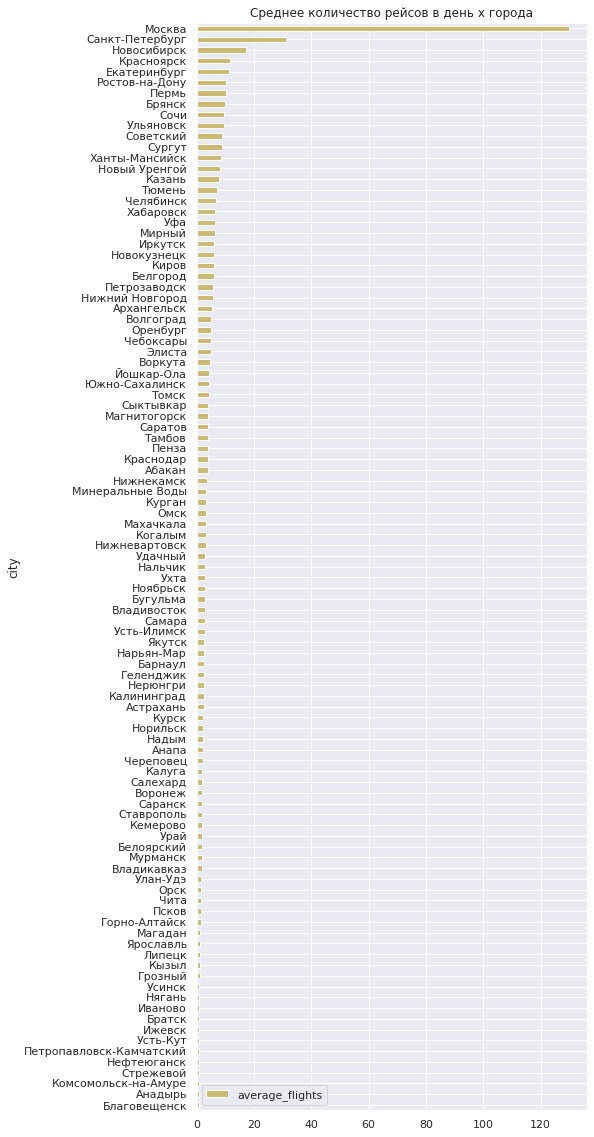

In [11]:
df2.sort_values(by="average_flights", ascending=True).plot(x='city', y="average_flights", kind ='barh', grid=True, figsize=(7, 20), title='Среднее количество рейсов в день х города', color='y')

В основном большинство рейсов ходят между городами федерального значения, городами миллионниками и т.п.

Большинство региональных городов имеют один рейс в день, скорее всего в сторону столицы.

Отобразим ТОП-10 городов по количеству рейсов:

In [12]:
display(df2.sort_values(by="average_flights", ascending=False).head(10))

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


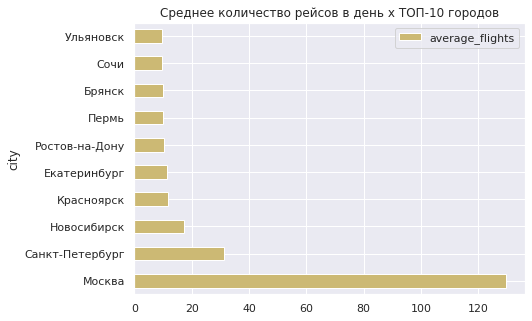

In [13]:
df2.sort_values(by="average_flights", ascending=False).head(10).plot(x='city', y="average_flights", kind ='barh', grid=True, figsize=(7, 5), title='Среднее количество рейсов в день х ТОП-10 городов', color='y')

Отобразили ТОП-10 городов по среднему количеству рейсов, прибывающих за день в августе 2018 года.

Москва - несомненный лидер. Также отрываются Санкт-Петербург и Новосибирск. Остальные города в ТОП-10 незначительно отличаются по количетсву рейсов за данный промежуток времени.
 
 Далее посмотрим какое количество рейсов приходилось на каждую модель самолета.

In [14]:
display(df.sort_values(by="flights_amount", ascending=False))

,model,flights_amount
6,Cessna 208 Caravan,4557
5,Bombardier CRJ-200,4446
7,Sukhoi SuperJet-100,4185
1,Airbus A321-200,960
2,Boeing 737-300,630
0,Airbus A319-100,607
3,Boeing 767-300,600
4,Boeing 777-300,300


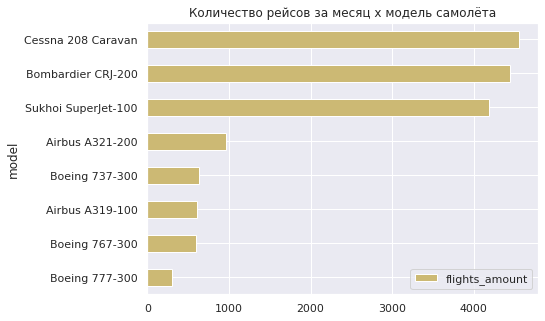

In [15]:
df.sort_values(by="flights_amount").head(10).plot(x='model', y="flights_amount", kind ='barh', grid=True, figsize=(7, 5), title='Количество рейсов за месяц х модель самолёта', color='y')

Самая популярная модель самолётов среди количетсва рейсов - Cessna 208 Caravan. На нее приходилось 4557 рейсов в августе. Наименее популярная модель по количеству рейсов - Boeing 777-300.

Это связано с тем, что Boeing 777-300 имеет 550 посадочных мест, в то время как Cessna 208 Caravan - 14.

Отсюда мы и можем сделать вывод: Cessna 208 Caravan – это короткие развлекательные полеты в районе аэроклуба.